In [ ]:
# Sources : 

# Effective Federal Funds Rate (EFFR)
# https://www.newyorkfed.org/markets/reference-rates/effr

# Target Range of the Federal Funds Rate (FFTR)
# https://www.federalreserve.gov/economy-at-a-glance-policy-rate.htm

# TBOND
# https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025

# ARIMA model
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [ ]:
# créer une fonction de scraping sur les EFFR
# "https://markets.newyorkfed.org/read?startDt=2000-01-01&endDt=2025-01-01&eventCodes=500&productCode=50&sort=postDt:-1,eventCode:1&format=csv"

In [457]:
pip install --upgrade git+https://github.com/Matteo-Bernard/EcoWatch.git

  Cloning https://github.com/Matteo-Bernard/EcoWatch.git to c:\users\matteo\appdata\local\temp\pip-req-build-io_g3dcd
  Resolved https://github.com/Matteo-Bernard/EcoWatch.git to commit 9b81f5596a38fb7f16e7ab8bd60a6f33bb8eb9a0
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/Matteo-Bernard/EcoWatch.git 'C:\Users\Matteo\AppData\Local\Temp\pip-req-build-io_g3dcd'


In [458]:
from EcoWatch.NelsonSiegelCurvature import NSC
from EcoWatch.Scraping import tbond
import pandas as pd
import numpy as np

### Scraping endogène and inendogène datas

In [459]:
effr = pd.read_csv('overnight_rates.csv', index_col='Effective Date')
effr.index = pd.to_datetime(effr.index, format='mixed')
effr = effr[effr['Rate Type'] == 'EFFR']['Rate (%)']
effr = effr.sort_index()
effr = effr.resample('W').last()
effr.name = 'effr'

In [460]:
tbonds = tbond('2000', '2025')
tbonds = tbonds.drop(['20 Yr', '30 Yr', '1.5 Month'], axis=1) # Drop the 20 and 30 year maturities and the 1.5 month maturity
tbonds = tbonds.interpolate(axis=1) # Interpolate missing values
tbonds = tbonds.dropna(axis=0)
tbonds = tbonds.resample('W').last()

# Define the maturities of the US Treasury Bonds
maturities = np.unique([
    int(col.split()[0]) / 12 if "Mo" in col else int(col.split()[0])
    for col in tbonds.columns
])

# Define the curve maturities
curve_maturities = np.arange(start=maturities.min(), stop=maturities.max()+maturities.min(), step=maturities.min()).round(4)

### Feature Engineering

In [461]:
# Define parameter bounds for optimization: 
bounds = [(0, 1), (-1, 1), (-1, 1), (0, 5)] # Intercept (β0), Slope (β1), Curvature (β2), and Lambda (λ)
x0 = [0.01, 0.01, 0.01, 0.5] # Initial guess for the optimization algorithm
method = 'trust-constr' # Optimization method used for minimization

# Create an instance of the Nelson-Siegel-Curvature class
NelsonSiegelCurvature = NSC(maturities=maturities, bounds=bounds, x0=x0, method=method)

# Adjust Nelson-Siegel parameters for the curve
nsc = NelsonSiegelCurvature.fit(yields=tbonds)

Fitting Nelson-Siegel: 221it [00:21,  6.36it/s]C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
Fitting Nelson-Siegel: 244it [00:24, 10.11it/s]C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self

In [462]:
data = pd.concat([nsc.shift(-1), effr], axis=1).dropna()

### Analyse de la stationarité de la série endogène (EFFR)

In [463]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(effr)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")

ADF Statistic: -3.4165
p-value: 0.0104
Critical Values:
   1% : -3.4356
   5% : -2.8638
   10% : -2.568


Hypothèses du test ADF :    
H0 (nulle) : la série est non stationnaire    
H1 (alternative) : la série est stationnaire

P-value < 0.05 --> H0 est rejetée à un seuil de 5%  

Puisque la série endogène est stationnaire nous utiliserons un modèle ARIMAX

### Analyse des composantes p et q (ACF/PACF)

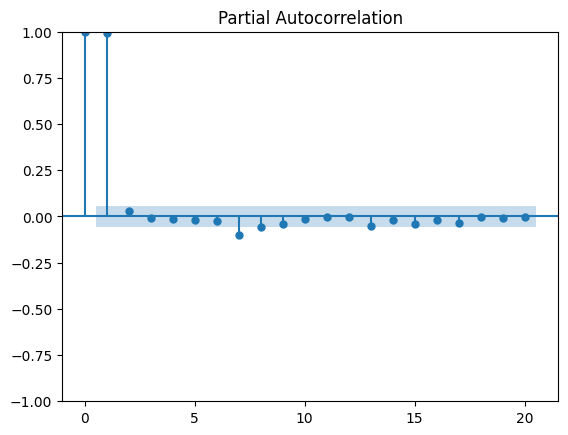

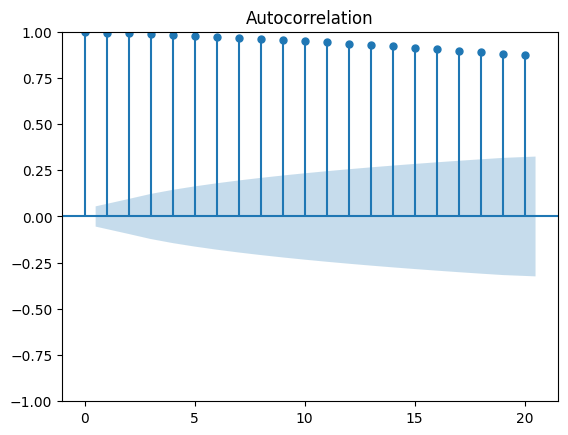

In [464]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_pacf(effr, lags=20)
plot_acf(effr, lags=20)
plt.show()

Estimation des ordres du modèle ARIMAX à la lecture des graphiques d'autocorrelation et d'autocorrelation partielle :    
p => 2 car le PACF est significatif jusqu'au lag 2  
d => 0 car la série est stationnaire    
q => 0 car l'ACF ne montre pas de coupure nette 

### Constrion du modèle ARIMAX

In [465]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(
    endog=data['effr'], # Variable endogène
    exog=data[['Intercept', 'Slope', 'Curvature']], # Variables exogènes
    order=(2, 0, 1), # modèle ARIMA d'ordre (p, d, q)
    trend='n', # Ne pas ajouter de tendance
)
model_fit = model.fit()
print(model_fit.summary())

C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   effr   No. Observations:                 1223
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 508.080
Date:                Fri, 11 Apr 2025   AIC                          -1002.161
Time:                        00:36:47   BIC                           -966.397
Sample:                    08-05-2001   HQIC                          -988.702
                         - 01-05-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    100.3314      1.647     60.931      0.000      97.104     103.559
Slope         70.0181      1.043     67.105      0.000      67.973      72.063
Curvature     19.9564      0.401     49.785      0.0

C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Validation du modèle ARIMAX

      lb_stat  lb_pvalue
10  20.831172   0.022302


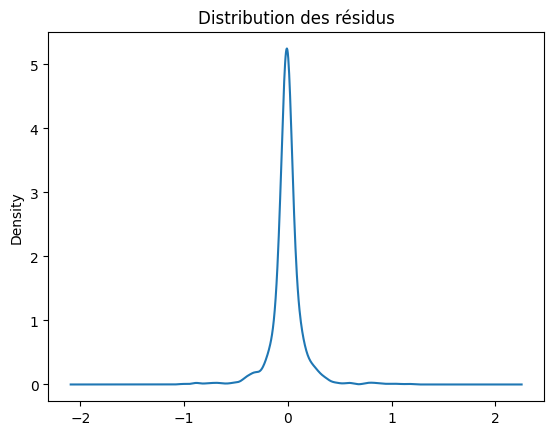

In [466]:
residuals = model_fit.resid

# Histogramme et QQ-plot
residuals.plot(kind='kde', title='Distribution des résidus')

# Test de Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(residuals, lags=[10], return_df=True)) # à mettre au propre


*Ajouter commentaire sur le bruit blanc*

### Prédictions à une semaine

In [467]:
nsc[['Intercept', 'Slope', 'Curvature', 'Lambda']].iloc[-1]

Intercept    0.049569
Slope       -0.004664
Curvature   -0.029788
Lambda       1.622887
Name: 2025-04-13 00:00:00, dtype: float64

In [468]:
forecast = model_fit.get_forecast(steps=1, exog=nsc[['Intercept', 'Slope', 'Curvature']].iloc[-55])
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

print("Prévision EFFR à 1 semaine :", forecast_mean.values[0])
print("Intervalle de confiance à 95 % :")
print(forecast_ci)

Prévision EFFR à 1 semaine : 5.448619454520926
Intervalle de confiance à 95 % :
            lower effr  upper effr
2025-01-12     5.13444    5.762799
